# X-AI with SHAP for Credit Risk Classification

### Load dataset

In [1]:
# import packages
import numpy as np
import pandas as pd 
import sklearn 
import lightgbm as lgb
import shap 
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# initialization javascript for visualization
shap.initjs()

In [3]:
# load dataset
data = pd.read_csv("dataset/german_credit_data.csv")
data.head()

,Id,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


### Preprocessing

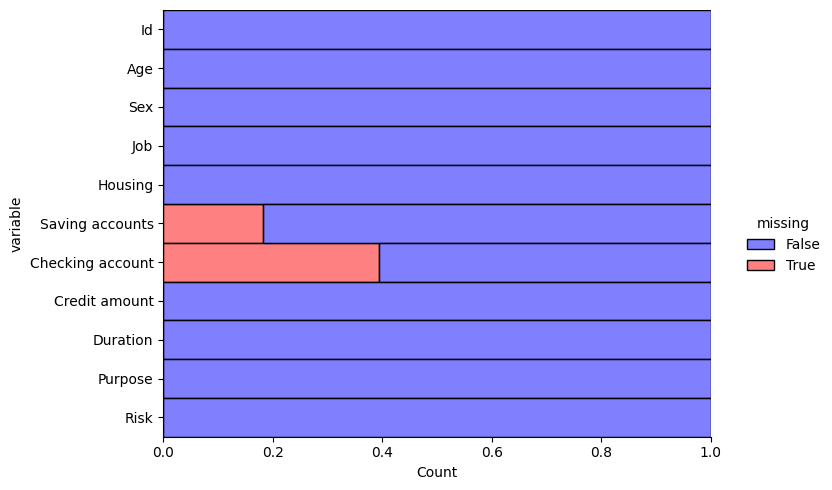

In [4]:
# check the missing values
sns.displot(
    data = data.isna().melt(value_name="missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 1.5,
    palette = "seismic"
)

plt.show()

In [5]:
# fill the missing values
data.fillna("unknown", inplace = True)

In [6]:
# preprocess categorical data in values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose", "Risk"]:
    le.fit(data[feature])
    data[feature] = le.transform(data[feature]) 

In [7]:
# import package
from sklearn.model_selection import train_test_split

# split independent and dependent variables
x = data.drop(columns = ["Id", "Risk"])
y = data["Risk"]

# split train and test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [8]:
feature_names = x.columns
feature_names

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose'],
      dtype='object')

### Training

In [13]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

# dictionary of hyperparameters
params = {    
    "num_leaves": [10, 20, 30],
    "learning_rate": [0.05, 0.1, 0.2],
    "feature_fraction": [0.8, 0.9, 1.0],
    "bagging_fraction": [0.7, 0.8, 0.9],
    "bagging_freq": [3, 5, 7],    
    "lambda_l1": [0, 1, 2],
    "lambda_l2": [0, 1, 2]    
}

In [14]:
# define the classifier
lgbm = LGBMClassifier(boosting_type = "gbdt", 
                      objective = "binary",
                      metric = "auc",
                      seed = 42,
                      verbose = -1)

In [15]:
# hyperparameter optimization with grid search
grid_lgbm = GridSearchCV(estimator = lgbm,  # classifier model
                         param_grid= params,    # dictionary of hyperparameters
                         cv = 5,    # 5-fold cross validation
                         scoring = "roc_auc",   # scoring metric
                         n_jobs = -1    # use all CPU cores
                    )
# fit LightGBM
grid_lgbm.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(metric='auc', objective='binary', seed=42,
                                      verbose=-1),
             n_jobs=-1,
             param_grid={'bagging_fraction': [0.7, 0.8, 0.9],
                         'bagging_freq': [3, 5, 7],
                         'feature_fraction': [0.8, 0.9, 1.0],
                         'lambda_l1': [0, 1, 2], 'lambda_l2': [0, 1, 2],
                         'learning_rate': [0.05, 0.1, 0.2],
                         'num_leaves': [10, 20, 30]},
             scoring='roc_auc')

In [16]:
# best hyperparameters
best_model = grid_lgbm.best_estimator_  
print(best_model)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, feature_fraction=0.8,
               lambda_l1=2, lambda_l2=0, learning_rate=0.05, metric='auc',
               num_leaves=10, objective='binary', seed=42, verbose=-1)


In [17]:
# the best parameters and score
best_params = grid_lgbm.best_params_
print("best params = ", best_params)
best_score = grid_lgbm.best_score_
print("best score = ", best_score)

best params =  {'bagging_fraction': 0.9, 'bagging_freq': 3, 'feature_fraction': 0.8, 'lambda_l1': 2, 'lambda_l2': 0, 'learning_rate': 0.05, 'num_leaves': 10}
best score =  0.7656366347214562


In [18]:
# re-train the model with th best parameters
best_model = LGBMClassifier(**best_params)
best_model.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9,

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, feature_fraction=0.8,
               lambda_l1=2, lambda_l2=0, learning_rate=0.05, num_leaves=10)

### Inference

In [19]:
import pickle

# function to save the model
def save_model(filename, model):
    with open(filename, "wb") as file:
        pickle.dump(model, file)

In [20]:
# save the model
save_model("models/lgbm_credit_risk_v1.pickle", best_model)

In [21]:
# function to load the model
def load_model(filename):
    with open(filename, "rb") as file:
        return pickle.load(file)

In [22]:
# recover the model
recover_model = load_model("models/lgbm_credit_risk_v1.pickle")

In [23]:
# take the recovered model to make predictions
y_pred = recover_model.predict(x_test)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [60]:
print("predictions = ", y_pred)
print("#test samples = ", len(y_pred))

predictions =  [1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1]
#test samples =  200


### SHAP Tree Explanation

In [25]:
# apply tree explainer
explainer = shap.TreeExplainer(recover_model)
shap_values = explainer.shap_values(x_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Global Explanation

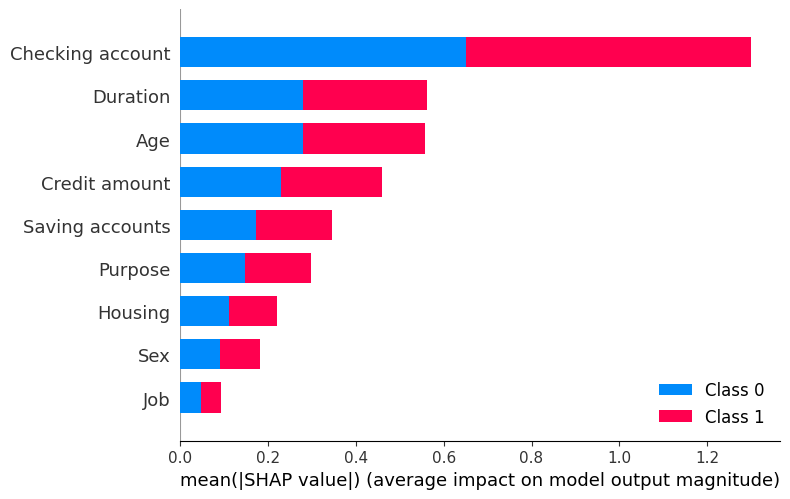

In [26]:
# global explainability with feature importance bar plots
shap.summary_plot(shap_values, x_test, feature_names = feature_names)

Partial dependence plot for Purpose


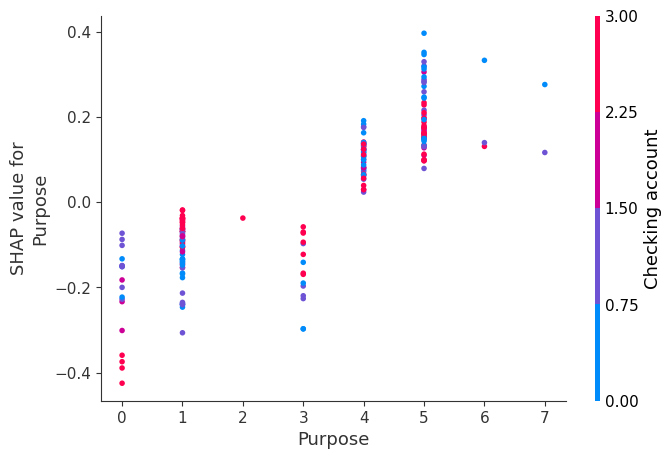

Partial dependence plot for Age


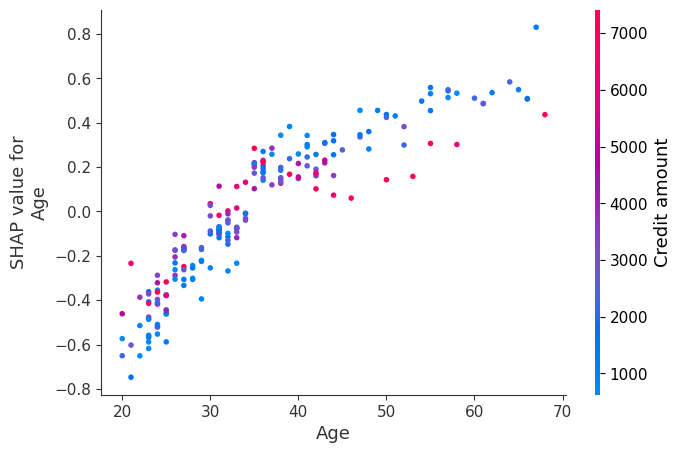

In [93]:
# global explainability with partial dependence plots (PDP)
for col in ["Purpose", "Age"]:
    print(f"Partial dependence plot for {col}")
    shap.dependence_plot(col, shap_values[1], x_test, display_features = x_test)

Local Explanation

In [79]:
# define the instance sample to explain
instance_idx = 101

In [80]:
y_pred[instance_idx]

1

In [87]:
# local explainability with force plots for class = 0
instance_class = 0
shap.force_plot(explainer.expected_value[instance_class], 
                shap_values[instance_class][instance_idx, :], 
                x_test.iloc[instance_idx, :])

In [88]:
# local explainability with force plots for class = 1
instance_class = 1
shap.force_plot(explainer.expected_value[instance_class], 
                shap_values[instance_class][instance_idx, :], 
                x_test.iloc[instance_idx, :])

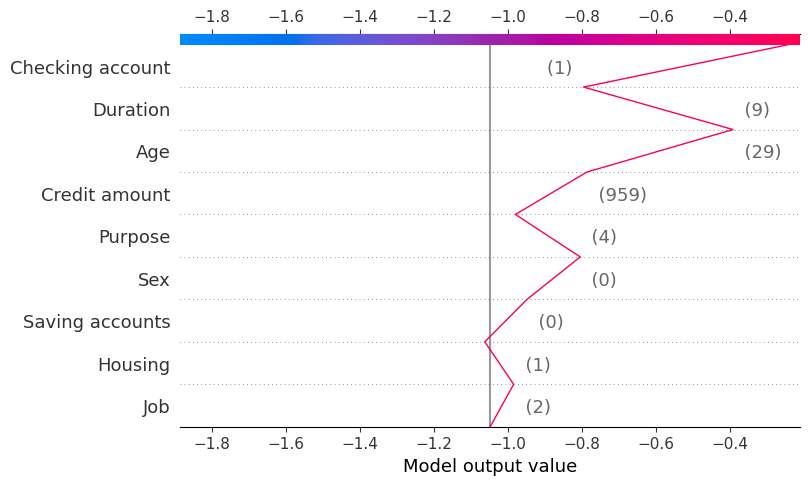

In [89]:
# local explainability with decision plots for class = 0
instance_class = 0
shap.decision_plot(explainer.expected_value[instance_class], 
                   shap_values[instance_class][instance_idx, :], 
                   x_test.iloc[instance_idx, :])

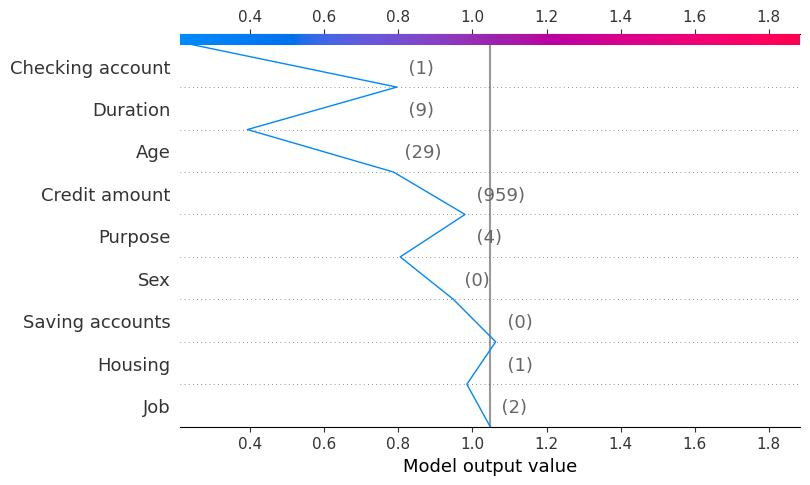

In [90]:
# local explainability with decision plots for class = 1
instance_class = 1
shap.decision_plot(explainer.expected_value[instance_class], 
                   shap_values[instance_class][instance_idx, :], 
                   x_test.iloc[instance_idx, :])